In [77]:
!python -m pip install -U plotly
!python -m pip install -U gensim
!python -m pip install -U kneed
!python -m pip install -U scikit-learn
!python -m pip install -U pyLDAvis
!python -m pip install -U torchvision 
!python -m pip install -U wordcloud

     |████████████████████████████████| 366 kB 4.9 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [2]:
import numpy as np
import pandas as pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis

import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from gensim.matutils import corpus2csc
import torch
import torchvision



/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [78]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt 

#!pip install kneed
from kneed import KneeLocator

from sklearn.cluster import KMeans 
from scipy.cluster import hierarchy 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.mixture import GaussianMixture

from gensim.models.doc2vec import Doc2Vec

from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud



In [4]:
from google.colab import files
files.upload()

Saving measures.py to measures.py


{'measures.py': b'from typing import List\r\nfrom matplotlib.pyplot import cohere\r\nimport pandas as pd\r\nimport numpy as np\r\nfrom gensim.models import LsiModel\r\nfrom gensim.models.coherencemodel import CoherenceModel\r\nfrom sklearn.metrics import cohen_kappa_score, adjusted_rand_score, silhouette_score\r\n\r\n"""\r\ncalculate the best amount of topics for LSI model\r\n"""\r\ndef best_num_topic(corpus, dictionary, max_n_topic)->List:\r\n    np.random.seed(0)\r\n    results = []\r\n\r\n    for t in range(2, max_n_topic):\r\n        lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=t)\r\n        corpus_lsi = lsi_model[corpus]\r\n\r\n        cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence=\'u_mass\')\r\n        score = cm.get_coherence()\r\n        tup = t, score\r\n        results.append(tup)\r\n\r\n    results = pd.DataFrame(results, columns=[\'topic\', \'score\'])\r\n    # lowest score means the best\r\n    s = pd.Series(results.score.values, index=re

In [5]:
import measures
from measures import get_coherence
from measures import get_silhouette_score


In [6]:
import plotly.io as pio
pio.renderers.default = "notebook"

In [7]:
def make_SVDtsne_2d(df, label=None, books=('a','b','c','d','e','f','g')):
  reduced = TruncatedSVD(n_components=7, random_state=0).fit_transform(df)

  tsne_results = TSNE(n_components=2, 
                      perplexity=40, 
                      init='pca', # globally more stable to initialization
                      learning_rate = 'auto',
                      n_iter=1000, 
                      random_state=0).fit_transform(reduced)

  df = pd.DataFrame()
  df['tsne-2d-one'] = tsne_results[:,0]
  df['tsne-2d-two'] = tsne_results[:,1]
  df['label_True'] = df_out['label'].loc[df_out['label'].isin(books)].reset_index(drop=True)
  print(df)
  if label is not None:
    dic = dict(enumerate(df_out['label'].loc[df_out['label'].isin(books)].unique()))
    lbl = list(label)
    for i, l in zip(range(0,len(lbl)), lbl):
      try:
        lbl[i] = dic[l].upper()
      except:
        lbl[i] = 'Outlier'
    df['label_Pred'] = lbl
  
  print(df)
  if label is None: fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color="label_True", symbol="label_True", width=1200, height=900)
  if label is not None: fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color="label_Pred", symbol="label_True", width=1200, height=900)

  fig.show()


In [8]:
def make_tsne_2d(df, label=None, books=('a','b','c','d','e','f','g')):
    # need to read raw our.csv first
    # df must be vectorized DataFrame
    
    tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=0)
    tsne_results = tsne.fit_transform(df)
    
    df = pd.DataFrame()
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]
    df['label_True'] = df_out['label'].loc[df_out['label'].isin(books)].reset_index(drop=True)
    if label is not None:
      dic = dict(enumerate(df_out['label'].unique()))
      lbl = list(label)
      for i, l in zip(range(0,len(lbl)), lbl):
        try:
          lbl[i] = dic[l].upper()
        except:
          lbl[i] = 'Outlier'
      df['label_Pred'] = lbl
    
    if label is None: fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color="label_True", symbol="label_True", width=1200, height=900)
    if label is not None: fig = px.scatter(df, x='tsne-2d-one', y='tsne-2d-two', color="label_Pred", symbol="label_True", width=1200, height=900)
    fig.show()

In [9]:
def elbow_method(data, number):
    wcss = []
    for i in range(1, number+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    kn = KneeLocator(range(1, 10+1), wcss, curve='convex', direction='decreasing')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, number+1)),
                            y=wcss))
    fig.add_vline(x=kn.knee, line_width=3, line_dash="dash", line_color="green")

    fig.update_layout(title='Elbow Method',
                      xaxis_title='Number of clusters',
                      yaxis_title='WCSS',
                      title_x=0.5,
                      height=500, 
                      width=800)
    fig.show()

In [10]:
def label_to_cluster_num(pred, k, books):
    pred_map = dict()
    offset = [(ord(label) - ord('a')) for label in books]

    for i in range(0, k):
        count = np.bincount(pred[i * 200 : i * 200 + 200])
        count.resize((1,k), refcheck=False) # resize row's dimension to 1xk
        count = count[0]
        index = np.where(count == max(count))[0][0]
        label =  chr(ord('a')+offset[i])
        pred_map[label] = index
        print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

    return pred_map

In [11]:
def compare_predict(trans_data, data, modl, vidl = None,
  n_clusters=5,
  linkage='average',
  n_components = 2,
  covariance_type = 'diag',
  random_state = 0,
  books=('a','b','c','d','e','f','g')):

  X = trans_data[data['label'].isin(books)]

  # clustering parameters
  if 'n_clusters' in modl.get_params():
    modl.set_params(n_clusters = n_clusters)
  if 'linkage' in modl.get_params():
    modl.set_params(linkage = linkage)
  # em parameters
  if 'n_components' in modl.get_params():
    modl.set_params(n_components = n_components)
  if 'covariance_type' in modl.get_params():
    modl.set_params(covariance_type = covariance_type)
  if 'random_state' in modl.get_params():
    modl.set_params(random_state = random_state)

  pred = modl.fit_predict(X)

  pred_map = label_to_cluster_num(pred=pred, k=len(books), books= books)
  label_data_in_books = data[data['label'].isin(books)]['label'] # retrieve label rows that belongs to any of the books
  mapped_label = [pred_map[label] for label in label_data_in_books]

  if vidl is not None:
    if vidl == 'tsne':
      make_tsne_2d(X, pred, books)
    if vidl == 'SVDtsne':
      make_SVDtsne_2d(X, pred, books)

  return modl, pred, mapped_label

In [12]:
url = 'https://drive.google.com/file/d/1NmGTSp5CLiCTPlQgP614TvNNv1TXDewU/view?usp=sharin'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_out = pd.read_csv(url)

df_out.drop('Unnamed: 0', axis=1, inplace=True)
df_out

,segment,label
0,act known circumst harm may accept gener test ...,a
1,aris whether represent part contract If contra...,a
2,section cite godbolt see F. N. B G fitzh abr d...,a
3,row bell c.c see treasur hidden anoth land D. ...,a
4,give trespass pretti nearli thing action case ...,a
...,...,...
1395,lamb chop fri tomato potato la crãªme rais bis...,g
1396,glass rhine wine IV glass water V glass champa...,g
1397,cover cloth set away cool place hour dinner ti...,g
1398,transpar veil egg cook white firm lift griddl ...,g


In [13]:
lda_df_out = df_out.copy()

In [14]:

for i in range(len(lda_df_out.index)):
  lda_df_out['segment'][i] = lda_df_out['segment'][i].split()

data_lemmatized = lda_df_out['segment'].tolist()
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
model_save_name = 'lda7_4.model'
path = F"/content/gdrive/My Drive/{model_save_name}" 
optimal_model = torch.load(path)

In [17]:
model_save_name = 'lda7_5.model'
path = F"/content/gdrive/My Drive/{model_save_name}" 
five_model = torch.load(path)


In [18]:
model_save_name = 'lda7_7.model'
path = F"/content/gdrive/My Drive/{model_save_name}" 
seven_model = torch.load(path)

In [21]:
df_lda = np.zeros(shape=(1400,4))
for i, row in enumerate(optimal_model[corpus]):
  for  j, (topic_num, prop_topic) in enumerate(row):
    df_lda[i, topic_num] = prop_topic

In [22]:
print(df_lda)

[[0.         0.         0.99924737 0.        ]
 [0.         0.0608542  0.9387368  0.        ]
 [0.         0.9991495  0.         0.        ]
 ...
 [0.         0.         0.         0.9990254 ]
 [0.         0.         0.         0.99902517]
 [0.         0.         0.         0.99902523]]


In [23]:
df_lda5 = np.zeros(shape=(1400,5))
for i, row in enumerate(five_model[corpus]):
  for  j, (topic_num, prop_topic) in enumerate(row):
    df_lda5[i, topic_num] = prop_topic

In [24]:
df_lda7 = np.zeros(shape=(1400,7))
for i, row in enumerate(seven_model[corpus]):
  for  j, (topic_num, prop_topic) in enumerate(row):
    df_lda7[i, topic_num] = prop_topic

In [25]:
print(df_lda5)

[[0.         0.         0.7632798  0.         0.23618729]
 [0.         0.         0.59059352 0.         0.40887353]
 [0.         0.99898064 0.         0.         0.        ]
 ...
 [0.         0.         0.         0.99895149 0.        ]
 [0.         0.         0.         0.9989512  0.        ]
 [0.         0.         0.         0.99895126 0.        ]]


In [26]:
print(df_lda7)

[[0.         0.0513428  0.05730856 ... 0.74287355 0.         0.14032833]
 [0.02984705 0.         0.33032367 ... 0.6386537  0.         0.        ]
 [0.         0.         0.58845824 ... 0.04419534 0.14674935 0.08808335]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06113566 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [27]:
lda_kmeans4, lda_kmeans4_pred, lda_kmeans4_cluster_num = compare_predict(df_lda, df_out, KMeans(), n_clusters= 4)

a:[169   1  28   2   0   0   0]	a mapped to 0
b:[  1   0 199   0   0   0   0]	b mapped to 2
c:[  3   0 197   0   0   0   0]	c mapped to 2
d:[197   1   0   2   0   0   0]	d mapped to 0
e:[  1 199   0   0   0   0   0]	e mapped to 1
f:[200   0   0   0   0   0   0]	f mapped to 0
g:[  0   1   0 199   0   0   0]	g mapped to 3


In [28]:
df_train_comp = pd.DataFrame({'predicted_label':lda_kmeans4_pred,
                              'mapped_label':lda_kmeans4_cluster_num
                              })

In [29]:
df_train_comp

,predicted_label,mapped_label
0,0,0
1,0,0
2,2,0
3,2,0
4,0,0
...,...,...
1395,3,3
1396,3,3
1397,3,3
1398,3,3


In [30]:
df_new = pd.concat([df_out, df_train_comp], axis=1)
df_new_a =df_new[0:200]
df_a_error = df_new_a.loc[df_new_a['predicted_label'] == 2]

In [31]:
df_a_error

,segment,label,predicted_label,mapped_label
2,section cite godbolt see F. N. B G fitzh abr d...,a,2,0
3,row bell c.c see treasur hidden anoth land D. ...,a,2,0
12,abr trespass pl cit y.b hen vii kelyng see bul...,a,2,0
31,limit liabil the rule alreadi prevail borrow a...,a,2,0
34,principl simpli give singl name case account I...,a,2,0
41,jackson M. M. skinner v. chapman ib n. swift v...,a,2,0
67,hors die default care the induc least plea see...,a,2,0
71,fearnley q.b y.b Ed IV pl a.d. cf ame case tor...,a,2,0
91,juri call consid whether accid unavoid occas f...,a,2,0
93,clayton see symon v. darknol second count mors...,a,2,0


In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [49]:
vectorizer_err = CountVectorizer()
tfidf_a_error = vectorizer_err.fit_transform(df_a_error['segment'])
tfidf_a_error_df = pd.DataFrame(tfidf_a_error.toarray())

#tfidf_a_error_df


In [65]:
plot_a = pd.DataFrame(tfidf_a_error.mean(axis=0))

#plot_a.reset_index(inplace=True)
plot_a = plot_a.T
plot_a.columns = ['Avg_Freq_a']
plot_a['word'] = vectorizer_err.get_feature_names_out()

In [66]:
plot_a

,Avg_Freq_a,word
0,0.035714,127
1,0.035714,447
2,0.035714,511
3,0.035714,576
4,0.035714,580
...,...,...
1413,0.071429,year
1414,0.214286,yelv
1415,0.107143,yet
1416,0.107143,york


In [68]:
#plot_a.reset_index(inplace=True)
#plot_a.columns = ['Word', 'Avg_Freq_a']
#plot_a['book']= 'a'
plot_a.sort_values(by='Avg_Freq_a', ascending=False, inplace=True)
#plot_err = plot_err.loc[plot_err.index.isin(plot_AE.index)]

plot_a

,Avg_Freq_a,word
962,3.178571,pl
406,2.178571,ed
218,2.000000,cf
733,1.964286,law
212,1.892857,case
...,...,...
594,0.035714,hobb
595,0.035714,hoc
596,0.035714,hold
597,0.035714,holgat


In [53]:
plot_a = plot_a.loc[plot_a['Avg_Freq_a']>0]

In [54]:
plota_new = plot_a[0:100]

In [55]:
model_topics = optimal_model.show_topics(formatted=False)
x = optimal_model.print_topics(num_words=50)

num_topics = 4

topic_words = []
for i in range(num_topics):
    tt = optimal_model.get_topic_terms(i,50)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [56]:
weight_words0 = []
tt0 = optimal_model.get_topic_terms(0,50)
for pair in tt0:
  weight_words0.append(pair[1])

weight_words2 = []
tt2 = optimal_model.get_topic_terms(2,50)
for pair in tt2:
  weight_words2.append(pair[1])



In [57]:
weight_words2

[0.008587652,
 0.007949457,
 0.0068600494,
 0.006314023,
 0.0059658135,
 0.0058692354,
 0.005046945,
 0.004744271,
 0.004580178,
 0.0043928158,
 0.0042507662,
 0.0040923227,
 0.0040788664,
 0.0040689963,
 0.00395057,
 0.0038874429,
 0.003855431,
 0.0037620629,
 0.0033588514,
 0.003339267,
 0.0032153833,
 0.0032062626,
 0.0032008835,
 0.0031527632,
 0.0031076353,
 0.0030478602,
 0.0029883797,
 0.002849585,
 0.0028474475,
 0.0027908478,
 0.0027837807,
 0.0027449385,
 0.0027102476,
 0.0026786728,
 0.0025761991,
 0.0025418513,
 0.0025402403,
 0.0025113544,
 0.0024735695,
 0.0024642246,
 0.0024456282,
 0.0023736267,
 0.0023554557,
 0.0023322927,
 0.0023312795,
 0.0022860528,
 0.002282249,
 0.0022699384,
 0.002247269,
 0.0021930847]

In [58]:
topic_words[2]

['the',
 'one',
 'gener',
 'would',
 'may',
 'It',
 'law',
 'case',
 'but',
 'natur',
 'must',
 'two',
 'I',
 'bee',
 'equat',
 'differ',
 'first',
 'question',
 'consid',
 'In',
 'point',
 'fact',
 'u',
 'function',
 'time',
 'present',
 'form',
 'man',
 'certain',
 'even',
 'line',
 'right',
 'relat',
 'consider',
 'calculu',
 'geometri',
 'order',
 'hive',
 'analysi',
 'shall',
 'differenti',
 'everi',
 'evid',
 'import',
 'determin',
 'still',
 'thi',
 'thu',
 'could',
 'make']

In [59]:
dftopic0 = {'words':topic_words[0], 'probability': weight_words0}
df_topic0 = pd.DataFrame(dftopic0)

dftopic2 = {'words':topic_words[2], 'probability': weight_words2}
df_topic2 = pd.DataFrame(dftopic2)

In [60]:
df_topic2

,words,probability
0,the,0.008588
1,one,0.007949
2,gener,0.006860
3,would,0.006314
4,may,0.005966
5,It,0.005869
6,law,0.005047
7,case,0.004744
8,but,0.004580
9,natur,0.004393


In [45]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [62]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=plot_a.word,
    y=plot_a.Avg_Freq_a,
    name='Avg_Freq_a',
    marker_color='grey'
))
fig.add_trace(go.Bar(
    x=df_topic0.words,
    y=(df_topic0.probability)*100,
    name='topic0',
    marker_color='black'
))
fig.add_trace(go.Bar(
    x=df_topic2.words,
    y=(df_topic2.probability)*5100,
    name='topic2',
    marker_color='red'
))


# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, plot_bgcolor='rgba(0,0,0,0)')
fig.show()

In [71]:
## the words included in topic in segments
topic0_word = df_topic0['words'].values.tolist()
topic2_word = df_topic2['words'].values.tolist()
segments_word = plot_a['word'].values.tolist()

top_0 = [x for x in topic0_word if x in segments_word]
top_2 = [x for x in topic2_word if x in segments_word]

In [75]:
top0_word = plot_a[plot_a['word'].isin(df_topic0['words'])]
top2_word = plot_a[plot_a['word'].isin(df_topic2['words'])]

In [99]:
text0 = " ".join(x for x in top0_word[0:20]['word'])
text2 = " ".join(x for x in top2_word[0:20]['word'])

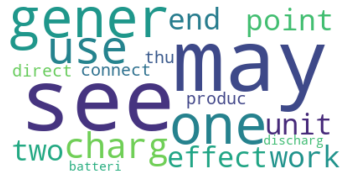

In [100]:
#top words in both segments and topic0
word_cloud0 = WordCloud(collocations = False, background_color = 'white').generate(text0)
# Display the generated Word Cloud
plt.imshow(word_cloud0, interpolation='bilinear')
plt.axis("off")
plt.show()

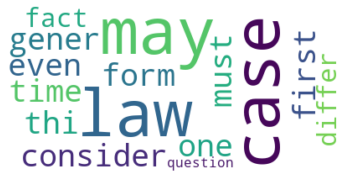

In [101]:
#top words in both segments and topic2
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)
# Display the generated Word Cloud
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
lda_kmeans5, lda_kmeans5_pred, lda_kmeans5_cluster_num = compare_predict(df_lda5, df_out, KMeans(), n_clusters= 5)

a:[ 28 147   0  24   1   0   0]	a mapped to 1
b:[ 16   1   0 183   0   0   0]	b mapped to 3
c:[199   0   0   1   0   0   0]	c mapped to 0
d:[196   1   1   1   1   0   0]	d mapped to 0
e:[  1   0 199   0   0   0   0]	e mapped to 2
f:[  3 197   0   0   0   0   0]	f mapped to 1
g:[  0   0   1   0 199   0   0]	g mapped to 4


In [30]:
lda_kmeans7, lda_kmeans7_pred, lda_kmeans7_cluster_num = compare_predict(df_lda7, df_out, KMeans(), n_clusters= 7)

a:[ 27  55   0   1   0 117   0]	a mapped to 5
b:[193   5   0   0   0   2   0]	b mapped to 0
c:[  3 197   0   0   0   0   0]	c mapped to 1
d:[  0 194   1   1   1   1   2]	d mapped to 1
e:[  0   0   0   0 152   0  48]	e mapped to 4
f:[  0   2 197   0   0   0   1]	f mapped to 2
g:[  0   0   0 197   1   0   2]	g mapped to 3


In [ ]:
lda_agglom4, lda_agglom4_pred, lda_agglom4_cluster_num = compare_predict(df_lda, df_out, AgglomerativeClustering(), n_clusters=4, linkage='ward')

a:[169   2  28   1   0   0   0]	a mapped to 0
b:[  1   0 199   0   0   0   0]	b mapped to 2
c:[  3   0 197   0   0   0   0]	c mapped to 2
d:[197   2   0   1   0   0   0]	d mapped to 0
e:[  1   0   0 199   0   0   0]	e mapped to 3
f:[200   0   0   0   0   0   0]	f mapped to 0
g:[  0 200   0   0   0   0   0]	g mapped to 1


In [31]:
lda_agglom5, lda_agglom5_pred, lda_agglom5_cluster_num = compare_predict(df_lda5, df_out, AgglomerativeClustering(), n_clusters=5, linkage='ward')

a:[168   7  24   1   0   0   0]	a mapped to 0
b:[  4   6 190   0   0   0   0]	b mapped to 2
c:[  0 195   5   0   0   0   0]	c mapped to 1
d:[  6 190   1   2   1   0   0]	d mapped to 1
e:[  0   1   0   0 199   0   0]	e mapped to 4
f:[198   2   0   0   0   0   0]	f mapped to 0
g:[  0   0   0 200   0   0   0]	g mapped to 3


In [32]:
lda_agglom7, lda_agglom7_pred, lda_agglom7_cluster_num = compare_predict(df_lda7, df_out, AgglomerativeClustering(), n_clusters=7, linkage='ward')

a:[ 0 31 98  1 68  0  2]	a mapped to 2
b:[  0   0   1   0  36   0 163]	b mapped to 6
c:[  0 188   0   0  12   0   0]	c mapped to 1
d:[  1 190   0   2   6   1   0]	d mapped to 1
e:[199   1   0   0   0   0   0]	e mapped to 0
f:[  0   3   0   0   0 197   0]	f mapped to 5
g:[  0   0   0 200   0   0   0]	g mapped to 3


In [33]:
lda_gmm5, lda_gmm5_pred, lda_gmm5_cluster_num = compare_predict(df_lda5, df_out, GaussianMixture(), n_components=5)

a:[  1 111   0  88   0   0   0]	a mapped to 1
b:[  4   0   0 196   0   0   0]	b mapped to 3
c:[176  10   0  14   0   0   0]	c mapped to 0
d:[106  21   0  73   0   0   0]	d mapped to 0
e:[  0   0 166  34   0   0   0]	e mapped to 2
f:[  0 187   0  13   0   0   0]	f mapped to 1
g:[  0   0   0  37 163   0   0]	g mapped to 4


In [35]:
lda_gmm4, lda_gmm4_pred, lda_gmm4_cluster_num = compare_predict(df_lda, df_out, GaussianMixture(), n_components=4)

a:[180   0  18   2   0   0   0]	a mapped to 0
b:[ 22   0 178   0   0   0   0]	b mapped to 2
c:[ 18   0 182   0   0   0   0]	c mapped to 2
d:[197   1   0   2   0   0   0]	d mapped to 0
e:[  1 199   0   0   0   0   0]	e mapped to 1
f:[200   0   0   0   0   0   0]	f mapped to 0
g:[  1   0   0 199   0   0   0]	g mapped to 3


In [34]:
lda_gmm7, lda_gmm7_pred, lda_gmm7_cluster_num = compare_predict(df_lda7, df_out, GaussianMixture(), n_components=7)

a:[ 19   0   0 153   0  28   0]	a mapped to 3
b:[  0   0   0 189   0  11   0]	b mapped to 3
c:[174   0   0  19   0   3   4]	c mapped to 0
d:[140   0   0  15   1  12  32]	d mapped to 0
e:[  0   0   0   0 155   0  45]	e mapped to 4
f:[  0 193   0   0   0   0   7]	f mapped to 1
g:[  0   0 141   0   0  10  49]	g mapped to 2
